### Class Definition

In [226]:
import pandas as pd
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt
import warnings

class pipeline_reduction(object):
    'Reduces the number of sections in a pipeline / flowline for increased simulation speed.'
    
    def __init__(self, df, xlabel = 'X', ylabel = 'Y', min_weld_size = 12.5, n_pipe_sec = 200):
        'Purpose: Initialises the pipeline_reduction class utility.'
        'Inputs:'
        'df: A Pandas dataframe object with the original pipeline profile data;'
        'xlabel: X axis label, default is X;'
        'ylabel: Y axis label, default is Y;'
        'min_weld_size: Resamples the original pipeline profile data to a minimum size size prior to further reduction;'
        'n_pipe_sec: Required number of final pipeline sections.'
        'Returns: N/A'
        
        #Initialise local variables
        self.df = df
        self.xlabel = xlabel
        self.ylabel = ylabel
        self.min_weld_size = min_weld_size
        self.n_pipe_sec = n_pipe_sec
        self.xstart = df[xlabel].iloc[0]
        self.xend = df[xlabel].iloc[-1]
        self.ystart = df[ylabel].iloc[0]
        self.yend = df[ylabel].iloc[-1]
                
    def _resample_df(self, df, new_size):
        'Purpose: Resamples data in the input Pandas dataframe to the specified pipe size.'
        'Inputs:'
        'df: A Pandas dataframe object with pipeline profile data;'
        'new_size: Required pipe section length;'
        'Returns: Pandas dataframe object with resampled data.'
        
        #Make a copy of the original dataframe
        df = df.copy()
        
        #Calculate DelX and DelY
        if 'X_Del' not in df.columns:
            df['X_Del'] = df[self.xlabel] - df[self.xlabel].shift(1)
        else:
            df[self.xlabel] = df['X_Del'].cumsum() + self.xstart
            df.at[0, self.xlabel] = self.xstart
        
        if 'Y_Del' not in df.columns:
            df['Y_Del'] = df[self.ylabel] - df[self.ylabel].shift(1)
        else:
            df[self.ylabel] = df['Y_Del'].cumsum() + self.ystart
            df.at[0, self.ylabel] = self.ystart
        
        #Calculate length of each segment
        if 'pipe_len' not in df.columns:
            df['pipe_len'] = np.sqrt(df['X_Del']**2 + df['Y_Del']**2)
        
        #Check that current min. pipe length > new_size
        curr_min = min(df['pipe_len'].iloc[1:])
        if curr_min > new_size:
            warnings.warn(f'Warning. Minimum pipe section is larger than the specified pipe section. Reseting to {curr_min}')
            new_size = curr_min
        
        # calculate pipeline length
        df['Length'] = df['pipe_len'].cumsum() + self.xstart
        df.at[0, 'Length'] = self.xstart
        fl_length = df['Length'].iloc[-1]
        
        #Perform 1-D interpolation
        length = df['Length'].values
        Y = df[self.ylabel].values
        f = interpolate.interp1d(length, Y) # Scipy Interpolation Function
        
        length_new = np.arange(self.xstart, fl_length+new_size, new_size) # Reduced pipeline length
        length_new[-1] = fl_length
        
        #Add data to new dataframe
        #length_new = pd.Series(length_new)
        #Y_new = pd.Series(f(length_new)) # Calculate y values for reduced length
        
        # Store to new dataframe
        df_new = pd.DataFrame()
        df_new['Length'] = length_new
        df_new[self.ylabel] = f(length_new)
        df_new['pipe_len'] = df_new['Length'] - df_new['Length'].shift(1)
        df_new['Y_Del'] = df_new[self.ylabel] - df_new[self.ylabel].shift(1)
        df_new['X_Del'] = np.sqrt(df_new['pipe_len']**2 - df_new['Y_Del']**2)
        df_new[self.xlabel] = df_new['X_Del'].cumsum() + self.xstart
        df_new.at[0, self.xlabel] = self.xstart
        
        # Calculate pipe angles using inverse the sine formula (theta = arcsin(O/H))
        df_new['Angles'] = np.arcsin(df_new['Y_Del'] / df_new['pipe_len']) * 180 / 3.141592653589793
        
        # Add pipe index
        df_new['pipe_idx'] = df_new.index 
        
        return df_new
    
    def _process_df(self):
        'Purpose: Pre-process the provided pipeline profile data prior to reduction.'
        'Inputs: N/A'
        'Outputs: N/A'
        
        # Resample dataset to min. specified weld size
        self.df_raw = self._resample_df(self.df, self.min_weld_size)
                
        # Calculate size of each pipe section for dicretisation
        length = self.df_raw['Length'].iloc[-1]
        pipe_size_ds = length / self.n_pipe_sec
        
        # Generate a temp. discretised dataset
        self.df_inp = self._resample_df(self.df, pipe_size_ds)
       
        # Generate the elevation profile
        self.df_ep = self.df_raw.copy()
        self.df_ep[1:] = self.df_ep[1:].sort_values(by = 'Angles').values
        
        # Interpolate over elevation profile
        self.df_ep2 = self._resample_df(self.df_ep, 12.5)
        
    def _angle_dist(self, df, bins):
        pass
    
    def _mse(self, df, pipe_idx):
        pass
    

### Unit Tests

In [227]:
PATH = "../data"
df = pd.read_csv(f'{PATH}/profile.csv')

In [228]:
pru = pipeline_reduction(df)

In [229]:
pru._process_df()

In [230]:
pru.df_ep

,Length,Y,pipe_len,Y_Del,X_Del,X,Angles,pipe_idx
0,0.0,-919.090000,NaN,NaN,NaN,0.000000,NaN,0.0
1,8475.0,-929.359769,12.5,-0.455373,12.491703,8474.719654,-2.087736,678.0
2,8450.0,-928.566330,12.5,-0.428858,12.492641,8449.732524,-1.966127,676.0
3,8500.0,-930.165057,12.5,-0.427700,12.492681,8499.706631,-1.960816,680.0
4,8412.5,-927.437299,12.5,-0.406745,12.493381,8412.249830,-1.864712,673.0
5,8437.5,-928.137472,12.5,-0.392000,12.493852,8437.239883,-1.797091,675.0
6,8200.0,-922.255026,12.5,-0.384933,12.494072,8199.814568,-1.764680,656.0
7,8487.5,-929.737357,12.5,-0.377588,12.494296,8487.213950,-1.730999,679.0
8,8387.5,-926.733990,12.5,-0.375107,12.494371,8387.259968,-1.719623,671.0
9,10187.5,-935.878499,12.5,-0.362315,12.494748,10187.013097,-1.660964,815.0


In [231]:
pru.df_ep2

,Length,Y,pipe_len,Y_Del,X_Del,X,Angles,pipe_idx
0,0.000000,-919.090000,NaN,NaN,NaN,0.000000,NaN,0
1,12.500000,-919.545373,12.500000,-0.455373,12.491703,12.491703,-2.087736,1
2,25.000000,-919.974231,12.500000,-0.428858,12.492641,24.984344,-1.966127,2
3,37.500000,-920.401931,12.500000,-0.427700,12.492681,37.477024,-1.960816,3
4,50.000000,-920.808676,12.500000,-0.406745,12.493381,49.970405,-1.864712,4
5,62.500000,-921.200676,12.500000,-0.392000,12.493852,62.464257,-1.797091,5
6,75.000000,-921.585609,12.500000,-0.384933,12.494072,74.958329,-1.764680,6
7,87.500000,-921.963197,12.500000,-0.377588,12.494296,87.452624,-1.730999,7
8,100.000000,-922.338304,12.500000,-0.375107,12.494371,99.946995,-1.719623,8
9,112.500000,-922.700620,12.500000,-0.362315,12.494748,112.441743,-1.660964,9


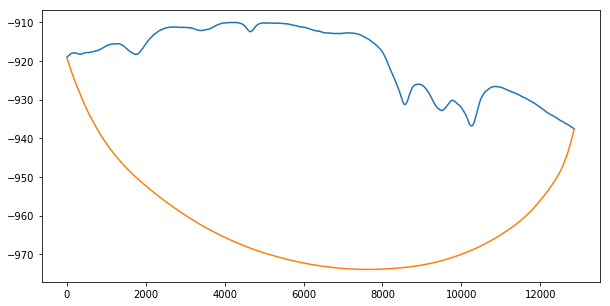

In [232]:
plt.figure(figsize=(10,5))
#plt.plot(df['Length'], df['Y'])
plt.plot(pru.df_raw['X'], pru.df_raw['Y'])
plt.plot(pru.df_ep2['X'], pru.df_ep2['Y'])
plt.show()